In [1]:
#default_exp verbatims/standard_themes_meta/training

In [2]:
#all_slow

In [3]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Standard Meta Themes - Training

> This module contains all the bits required to train and evaluate meta standard theme models.  These are models which, for a given verbatim related to a standard tehem, predicts the sentiment relative to *that* theme and whether it should be used as an example

In [4]:
#export
import os, datetime
import sklearn.metrics as skm

from fastai import metrics as fa_metrics
from fastai.text.all import *
from transformers import *
from blurr.utils import *
from blurr.data.core import *
from blurr.modeling.all import MultiTargetLoss
from blurr.modeling.core import *

from tritonlytics_ai.utils import *
from tritonlytics_ai.verbatims.core import *

In [5]:
#hide
import pdb, gc

# pandas and plotting config
import seaborn as sns
sns.set_style('whitegrid')

plt.rcParams['figure.figsize'] = (9,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

from nbdev.showdoc import *
from fastcore.test import *

In [6]:
#hide
from fastai import __version__ as fa_version
from torch import __version__ as pt_version
from transformers import __version__ as hft_version

print(f'Using pytorch {pt_version}')
print(f'Using fastai {fa_version}')
print(f'Using transformers {hft_version}')

Using pytorch 1.6.0
Using fastai 2.0.16
Using transformers 3.3.1


In [7]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}')

Using GPU #1


In [8]:
train_config = {}

## Data

In [9]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = 'facebook/bart-base' #"bert-base-cased" #"bert-base-uncased" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.attention_probs_dropout_prob = 0.1 * 2
config.hidden_dropout_prob = 0.1 * 2

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

In [10]:
df = get_meta_standard_theme_train_data(train_config=train_config)
train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]

dls = get_meta_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=train_config)

In [11]:
b = dls.one_batch()
len(b), b[0]['input_ids'].shape, b[1].shape, b[2].shape

(3, torch.Size([8, 468]), torch.Size([8]), torch.Size([8]))

## Training

In [12]:
m_pre = f'exp_{m_pre_standard_themes_meta}'
m_suf = m_suf_standard_themes_meta

Configure our **metrics**

In [13]:
#export
# define metrics
def sentiment_mse(preds, *targs):
    return fa_metrics.mse(preds[0], targs[0])

def is_example_acc(preds, *targs):
    return fa_metrics.accuracy(preds[1], targs[1])

In [14]:
#export
def get_metrics(train_config={}):
    config = {**meta_standard_themes_train_config, **train_config}
    return [ sentiment_mse, is_example_acc ]

Configure our **loss**

In [15]:
is_example_weights = list(np.max(train_df.is_example.value_counts()) /train_df.is_example.value_counts())
print(is_example_weights)

[1.0, 115.48148148148148]


In [16]:
# define our custom multi-target loss
loss_func = MultiTargetLoss(loss_classes=[MSELossFlat, CrossEntropyLossFlat],
                            loss_classes_kwargs=[{}, {'weight': FloatTensor(is_example_weights).to('cuda:1')}],
                            weights=[1, 0.1], 
                            reduction='mean')

In [17]:
#export
def get_loss_func(dls, train_df=None, use_weighted=False):
    loss_classes_kwargs = [{}, {}]
    
    if (use_weighted and train_df is not None):
        is_example_weights = list(np.max(train_df.is_example.value_counts()) /train_df.is_example.value_counts())
        loss_classes_kwargs[1] = {'weight': FloatTensor(is_example_weights).to(dls.device)}
    
    loss_func = MultiTargetLoss(loss_classes=[MSELossFlat, CrossEntropyLossFlat],
                                loss_classes_kwargs=loss_classes_kwargs,
                                weights=[1, 0.1], 
                                reduction='mean')
        
    return loss_func

In [18]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=False)
test_is(type(tst_loss_func), MultiTargetLoss)

In [19]:
tst_loss_func = get_loss_func(dls, train_df, use_weighted=True)
test_is(type(tst_loss_func), MultiTargetLoss)
test_eq(len(tst_loss_func.loss_funcs[1].func.weight), len(dls.c))
test_eq(dls.device, tst_loss_func.loss_funcs[1].func.weight.device)

Configure our callbacks

In [20]:
#export
class Meta_MM_HF_BaseModelCallback(HF_BaseModelCallback):
    def __init__(self, cls_idx=0):
        super().__init__()
        self.cls_idx = cls_idx
        
    def after_pred(self):
        super().after_pred()
        if (self.learn.pred[0].dim() == 3):
            self.learn.pred = (self.learn.pred[0][:,self.cls_idx,:], self.learn.pred[1][:,self.cls_idx,:])

In [21]:
best_model_cb = SaveModelCallback(monitor='valid_loss', 
                                  comp=np.less, 
                                  reset_on_fit=False,
                                  fname=f'{m_pre}mm_bestmodel{m_suf}')

In [22]:
#export
def get_cbs(train_config={}):
    config = {**meta_standard_themes_train_config, **train_config}
    
    best_model_cb = SaveModelCallback(monitor=config['save_model_monitor'], 
                                      comp=config['save_model_comp'], 
                                      fname=config['save_model_filename'],
                                      reset_on_fit=False)
    
    return [Meta_MM_HF_BaseModelCallback], [best_model_cb] # (learn_cbs, fit_cbs)

Configure our final model by updating our hf_model.classifier for multi-modal tasks

In [23]:
#hide

# class Meta_MM(Module):
#     def __init__(self, in_features=768, inner_dim=768, p=0.0): 
#         super().__init__()
#         self.dense = nn.Linear(in_features, inner_dim)
#         self.dropout = nn.Dropout(p=p)
#         self.pred_is_example = nn.Linear(inner_dim, 2, bias=False)
#         self.pred_avg_sentiment = nn.Linear(inner_dim, 1, bias=False)
#         self.pred_avg_sent_range = SigmoidRange(1., 5.1)
        
#     def forward(self, x):
#         x = self.dropout(x)
#         x = self.dense(x)
#         x = torch.tanh(x)
#         x = self.dropout(x)
#         is_example = self.pred_is_example(x)
#         avg_sentiment = self.pred_avg_sent_range(self.pred_avg_sentiment(x))
        
#         return avg_sentiment, is_example

In [24]:
#export
class Meta_MM(Module):
    def __init__(self, in_features=50): 
        super().__init__()
        self.pred_is_example = nn.Linear(in_features, 2, bias=False)
        self.pred_avg_sentiment = nn.Linear(in_features, 1, bias=False)
        self.pred_avg_sent_range = SigmoidRange(1., 5.1)
        
    def forward(self, x):
        is_example = self.pred_is_example(x)
        avg_sentiment = self.pred_avg_sent_range(self.pred_avg_sentiment(x))
        
        return avg_sentiment, is_example

In [25]:
last_layer = list(hf_model.named_children())[-1]

In [26]:
last_layer_name = last_layer[0]; last_layer_name

'classification_head'

In [27]:
in_features = hf_model._modules[last_layer_name].dense.in_features

In [28]:
hf_model._modules[last_layer_name] = Meta_MM(in_features=in_features)

In [29]:
#hide
# in_features = list(last_layer[1].children())[0].in_features; in_features
# mm_model = nn.Sequential(list(hf_model.named_children())[:-1][0][1])
# mm_model.add_module(name='classifier', module=MM(in_features=768))
# hf_model._modules['classifier'] = hf_model._modules.pop(last_layer_name)

Configure the Learner

In [30]:
learn_metrics = [sentiment_mse, is_example_acc]

learn_cbs = [Meta_MM_HF_BaseModelCallback]
fit_cbs = [best_model_cb]

# build learner
model =HF_BaseModelWrapper(hf_model)

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                loss_func=loss_func,
                metrics=learn_metrics,
                cbs=learn_cbs,
                splitter=hf_splitter,
                path=STANDARD_THEME_META_PATH)

learn.create_opt() # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [31]:
# learn.blurr_summary()

In [32]:
# learn.show_training_loop()

In [33]:
# Note: Run this to test the model and comment out afterwards as it needlessly contributes to GPU RAM utilization :(
# preds = model(b[0]); preds[0][0].shape, preds[0][1].shape

In [34]:
#export
def get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, use_fp16=True,
                opt_func=partial(Adam, mom=0.9, sqr_mom=0.98, eps=1e-6, weight_decay=0.1),
                train_config={}):
    config = {**meta_standard_themes_train_config, **train_config}
    
    # swap out classifier for our Meta_MM module
    last_layer = list(hf_model.named_children())[-1]
    last_layer_name = last_layer[0]
    in_features = hf_model._modules[last_layer_name].dense.in_features
    hf_model._modules[last_layer_name] = Meta_MM(in_features=in_features)
    
    # build learner
    model = HF_BaseModelWrapper(hf_model)
    loss_func = get_loss_func(dls, train_df, use_weighted_loss)
    learn_cbs, fit_cbs = get_cbs(config)
    learn_metrics = get_metrics(config)

    learn = Learner(dls, model, loss_func=loss_func, opt_func=opt_func, 
                    metrics=learn_metrics, cbs=learn_cbs, splitter=hf_splitter, path=config['learner_path'])
    
    if (use_fp16): learn = learn.to_fp16()
    learn.create_opt() # -> will create your layer groups based on your "splitter" function
    learn.freeze()
    
    return learn, fit_cbs

(9.12010818865383e-08, 1.3182567499825382e-06)

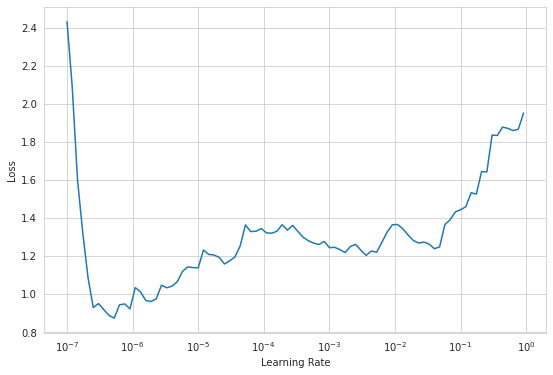

In [35]:
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [36]:
learn.fit_one_cycle(1, lr_max=lr_min, cbs=fit_cbs)
# learn.fit_flat_cos(10, lr_max=lr_min, cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,sentiment_mse,is_example_acc,time
0,1.036354,1.082641,1.049410,0.992374,01:50


Better model found at epoch 0 with valid_loss value: 1.0826414823532104.


(6.309573450380412e-08, 1.9054607491852948e-06)

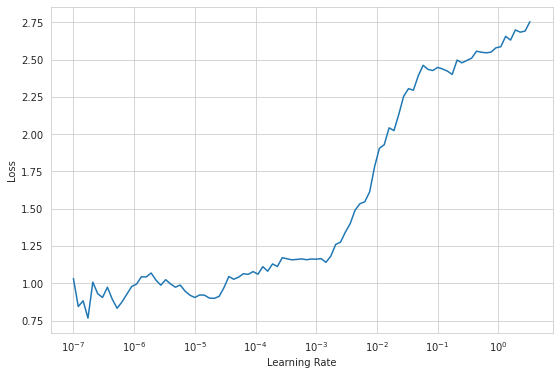

In [37]:
learn.unfreeze()
lr_min, lr_steep = learn.lr_find(); lr_min, lr_steep

In [38]:
learn.fit_one_cycle(10, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
# learn.fit_flat_cos(5, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs, pct_start=0.72)

epoch,train_loss,valid_loss,sentiment_mse,is_example_acc,time
0,1.027084,1.054320,1.021738,0.992374,03:31
1,0.936953,0.976245,0.945775,0.992374,03:30
2,0.989441,0.899718,0.871404,0.992374,03:31
3,0.791071,0.856363,0.829734,0.992374,03:31
4,0.837001,0.827587,0.801971,0.992374,03:32
5,0.878845,0.810074,0.785196,0.992374,03:31
6,0.858598,0.799488,0.775016,0.992374,03:31
7,0.826598,0.794812,0.770538,0.992374,03:31
8,0.787188,0.793767,0.769540,0.992374,03:31
9,0.797669,0.793727,0.769503,0.992374,03:31


Better model found at epoch 0 with valid_loss value: 1.054320216178894.
Better model found at epoch 1 with valid_loss value: 0.9762446880340576.
Better model found at epoch 2 with valid_loss value: 0.8997179865837097.
Better model found at epoch 3 with valid_loss value: 0.8563631176948547.
Better model found at epoch 4 with valid_loss value: 0.8275868892669678.
Better model found at epoch 5 with valid_loss value: 0.810073733329773.
Better model found at epoch 6 with valid_loss value: 0.7994878888130188.
Better model found at epoch 7 with valid_loss value: 0.7948122024536133.
Better model found at epoch 8 with valid_loss value: 0.7937671542167664.
Better model found at epoch 9 with valid_loss value: 0.7937271595001221.


In [39]:
learn.save(f'{m_pre}mm{m_suf}')

Path('data/classification/standard_themes/meta/models/exp_mm_multitask_hf.pth')

Export model for inference

In [40]:
learn.export(fname=f'{m_pre}export_mm{m_suf}.pkl')

Look at results

In [41]:
learn = learn.load(f'{m_pre}mm_bestmodel{m_suf}')

In [42]:
scores = dict(zip(learn.recorder.metric_names[2:], learn.validate())); scores

{'valid_loss': 0.7937271595001221,
 'sentiment_mse': 0.7695026993751526,
 'is_example_acc': 0.9923737049102783}

In [43]:
learn.show_results(learner=learn, max_n=2) 

,text,text_,category,target1,target2
0,"theme: Have Voice within my Institution/Valued Member of my Institution comment: I am satisfied with my department but very dissatisfied with ANR at the state/headquarters level. In my department, I have a voice, can influence small decisions and am recognized for my efforts. At the state level, I feel my voice is not heard or my importance is not recognized.\r\n\r\nThese feelings stem from a couple of more specific grievances: \r\n1) Continued/Increased inefficiencies, red tape and lack of progress clarity with administrative processes (eg hiring, grants, finance), such that deliverables cannot be met, ill-will is bred with funders & clientele and grant funds are lost, unexpended. And I spend large amounts of my time pestering people to do their job, rather than getting to do mine.\r\n2) Continued lack of communication of what the road map and benchmarks are to emerge for our budget and staffing crisis. \r\n3) Continued investment in expensive upper-level positions of leadership at HQ and lack of investment in county-based academic and staff positions. \r\n\r\nI generally feel that when I try to innovate through these lean time, I am stymied by HQ in some way. I feel like our Vice President in particular does not understand what a crisis we are in. We are not shuffling talent because millenials like to change jobs. We are hemorrhaging talent because ANR is a spirit-stomping place to work, and we'll continue to do so if systems are so inefficient they get in the way of us doing our actual job and staffing levels means we have to do 2-3 times the work of our predecessors.",2.0,0,"(2.2624571323394775,)",0
1,"theme: Advancement and Training Opportunities comment: Insights as alumna/former student of UCSD, working on main campus 3.5+ years, Mexican-American female & varied experience from start-up to non-profit to corporate:\r\n1. Dept/Culture:All, not just leadership/HR- trained yearly on effective leadership, diversity/inclusivity, utilizing technology & innovative ideas on team dynamics/future of work. Workshops at Price?\r\n2. As non-profit, yes, ""Do more with Less""- YET the level of stress/expectations of work (e.g.7:30A-6:30P or later-every day- work through lunch/breaks) has been a big issue for many. Non-work/life balance= plethora of health/sick issues\r\n3. Parking (no surprise): $90 per month but no spots available? Yet, 24/7 A spots open at Gilman? Perhaps: bus from further area= cheaper to staff? Are Staff (lowest on bureaucratic totem pole) giving 20 minutes of our own time each day (minimum) to/from work? Time=greatest commodity to humanity. How can we then best serve students?\r\n4. Coaching/leadership classes: for All, not just Leadership/Managers\r\n5. PPS: a month to get a response (time-sensitive issues & only 1 person knows the answer) can be incredibly stressful/error-prone\r\n6. Public funds can't be used for (parking)? Communicate: certain decisions (limited funding, strategy); where resources are going? Connect choices to mission!\r\n7. Student worker pay\r\n8. Where's RASC retirement? \r\n9. TRANSPARENCY on pay/incentives- my supervisor makes 3X my salary...\r\n10. MANDATORY: Leaders MUST take technology courses, be computer literate",3.0,0,"(2.4497625827789307,)",0


Use it for inference

In [44]:
inf_learn = load_learner(STANDARD_THEME_META_PATH/f'{m_pre}export_mm{m_suf}.pkl')

In [45]:
inf_learn.blurr_predict('theme: Benefits comment: We are not paid enough and the benefits are horrible')

(((2.6005783081054688), '0'), tensor([[2.6006]]), tensor([[2.6006]]))

Review final validation loss for best model

In [46]:
learn = learn.load(f'{m_pre}mm_bestmodel{m_suf}')
probs, targs, loss = learn.get_preds(dl=dls.valid, with_loss=True)

print(f'Validation Loss: {loss.mean()}')
# print(f'Validation Loss (per label): {loss.mean(dim=0)}') # ... no longer works (see forum comment from sylvain)

Validation Loss: 0.9588940143585205


In [47]:
for prob_sent, prob_example, targ_sent, targ_example in zip(*probs,*targs):
    print(prob_sent, targ_sent, torch.argmax(prob_example, dim=-1), targ_example)

tensor([2.7894]) tensor(2.) tensor(0) tensor(0)
tensor([2.6475]) tensor(2.) tensor(0) tensor(0)
tensor([3.0582]) tensor(4.) tensor(0) tensor(0)
tensor([2.7580]) tensor(2.) tensor(0) tensor(0)
tensor([2.7090]) tensor(4.) tensor(0) tensor(0)
tensor([1.8975]) tensor(2.) tensor(0) tensor(0)
tensor([2.4645]) tensor(5.) tensor(0) tensor(0)
tensor([2.3233]) tensor(2.) tensor(0) tensor(0)
tensor([2.4300]) tensor(3.) tensor(0) tensor(0)
tensor([2.3552]) tensor(4.) tensor(0) tensor(0)
tensor([2.5657]) tensor(2.) tensor(0) tensor(0)
tensor([2.4256]) tensor(5.) tensor(0) tensor(0)
tensor([2.4464]) tensor(2.) tensor(0) tensor(0)
tensor([2.4220]) tensor(2.) tensor(0) tensor(0)
tensor([2.2429]) tensor(1.) tensor(0) tensor(0)
tensor([2.2005]) tensor(1.5000) tensor(0) tensor(0)
tensor([2.0814]) tensor(5.) tensor(0) tensor(0)
tensor([2.6258]) tensor(3.) tensor(0) tensor(0)
tensor([2.1605]) tensor(2.) tensor(0) tensor(0)
tensor([2.7353]) tensor(3.) tensor(0) tensor(0)
tensor([2.6606]) tensor(2.) tensor(0

tensor([2.6794]) tensor(3.) tensor(0) tensor(0)
tensor([2.4628]) tensor(2.) tensor(0) tensor(0)
tensor([2.2614]) tensor(2.) tensor(0) tensor(0)
tensor([2.3760]) tensor(2.) tensor(0) tensor(0)
tensor([2.7591]) tensor(4.) tensor(0) tensor(0)
tensor([2.5904]) tensor(1.) tensor(0) tensor(0)
tensor([2.1484]) tensor(2.) tensor(0) tensor(0)
tensor([2.2635]) tensor(2.) tensor(0) tensor(0)
tensor([2.4907]) tensor(2.) tensor(0) tensor(0)
tensor([2.5291]) tensor(2.) tensor(0) tensor(0)
tensor([2.3914]) tensor(2.) tensor(0) tensor(0)
tensor([2.2377]) tensor(3.) tensor(0) tensor(0)
tensor([2.3336]) tensor(3.) tensor(0) tensor(0)
tensor([2.6927]) tensor(2.) tensor(0) tensor(0)
tensor([2.1433]) tensor(2.) tensor(0) tensor(0)
tensor([2.4970]) tensor(4.) tensor(0) tensor(0)
tensor([2.1543]) tensor(3.) tensor(0) tensor(0)
tensor([2.3084]) tensor(2.) tensor(0) tensor(0)
tensor([2.6217]) tensor(2.) tensor(0) tensor(0)
tensor([2.5026]) tensor(2.) tensor(0) tensor(0)
tensor([2.3798]) tensor(2.) tensor(0) te

tensor([2.4621]) tensor(2.) tensor(0) tensor(0)
tensor([2.9249]) tensor(3.) tensor(0) tensor(0)
tensor([2.1781]) tensor(2.) tensor(0) tensor(0)
tensor([2.5551]) tensor(5.) tensor(0) tensor(0)
tensor([2.5121]) tensor(2.) tensor(0) tensor(0)
tensor([2.2496]) tensor(3.) tensor(0) tensor(0)
tensor([2.6290]) tensor(2.) tensor(0) tensor(0)
tensor([2.2365]) tensor(2.) tensor(0) tensor(0)
tensor([2.2332]) tensor(2.) tensor(0) tensor(0)
tensor([2.1536]) tensor(2.) tensor(0) tensor(0)
tensor([2.3629]) tensor(3.) tensor(0) tensor(0)
tensor([2.4754]) tensor(2.) tensor(0) tensor(0)
tensor([2.4296]) tensor(2.) tensor(0) tensor(0)
tensor([2.4886]) tensor(3.) tensor(0) tensor(0)
tensor([2.2610]) tensor(2.) tensor(0) tensor(0)
tensor([2.5620]) tensor(2.) tensor(0) tensor(0)
tensor([2.9298]) tensor(3.) tensor(0) tensor(0)
tensor([2.5563]) tensor(3.) tensor(0) tensor(0)
tensor([2.6222]) tensor(2.) tensor(0) tensor(0)
tensor([2.6301]) tensor(3.) tensor(0) tensor(0)
tensor([2.4498]) tensor(3.) tensor(0) te

tensor([2.7350]) tensor(3.) tensor(0) tensor(0)
tensor([2.4205]) tensor(2.) tensor(0) tensor(0)
tensor([2.3880]) tensor(2.) tensor(0) tensor(0)
tensor([2.4821]) tensor(2.) tensor(0) tensor(1)
tensor([2.3173]) tensor(3.) tensor(0) tensor(0)
tensor([2.4594]) tensor(2.) tensor(0) tensor(0)
tensor([2.5217]) tensor(3.) tensor(0) tensor(0)
tensor([2.3585]) tensor(2.) tensor(0) tensor(0)
tensor([2.7755]) tensor(3.) tensor(0) tensor(0)
tensor([2.6170]) tensor(2.) tensor(0) tensor(0)
tensor([2.2331]) tensor(2.) tensor(0) tensor(0)
tensor([2.4565]) tensor(2.) tensor(0) tensor(0)
tensor([2.2849]) tensor(3.) tensor(0) tensor(0)
tensor([2.1735]) tensor(1.5000) tensor(0) tensor(0)
tensor([2.5007]) tensor(2.) tensor(0) tensor(0)
tensor([2.5685]) tensor(4.) tensor(0) tensor(0)
tensor([2.0086]) tensor(2.) tensor(0) tensor(0)
tensor([2.4141]) tensor(4.) tensor(0) tensor(0)
tensor([2.5783]) tensor(3.) tensor(0) tensor(0)
tensor([2.4658]) tensor(3.) tensor(0) tensor(0)
tensor([2.6401]) tensor(2.) tensor(0

tensor([2.4566]) tensor(2.) tensor(0) tensor(0)
tensor([1.8993]) tensor(2.) tensor(0) tensor(0)
tensor([2.4712]) tensor(2.) tensor(0) tensor(0)
tensor([2.5343]) tensor(3.) tensor(0) tensor(0)
tensor([2.5269]) tensor(3.) tensor(0) tensor(0)
tensor([2.7743]) tensor(2.) tensor(0) tensor(0)
tensor([1.9336]) tensor(2.) tensor(0) tensor(0)
tensor([2.6354]) tensor(3.) tensor(0) tensor(0)
tensor([2.1727]) tensor(2.) tensor(0) tensor(0)
tensor([2.3667]) tensor(1.) tensor(0) tensor(0)
tensor([2.3931]) tensor(2.) tensor(0) tensor(0)
tensor([2.3524]) tensor(1.) tensor(0) tensor(0)
tensor([2.4021]) tensor(4.) tensor(0) tensor(0)
tensor([2.5007]) tensor(3.) tensor(0) tensor(0)
tensor([2.5289]) tensor(2.) tensor(0) tensor(0)
tensor([2.2333]) tensor(3.) tensor(0) tensor(0)
tensor([2.2254]) tensor(2.) tensor(0) tensor(0)
tensor([2.3390]) tensor(1.) tensor(0) tensor(0)
tensor([2.1136]) tensor(3.) tensor(0) tensor(0)
tensor([2.9065]) tensor(5.) tensor(0) tensor(0)
tensor([2.2463]) tensor(2.) tensor(0) te

In [48]:
STANDARD_THEME_SAW_LABELS[:5]

['adequate_staffing',
 'advancement_and_training_opportunities',
 'appropriate_stress_work_assigned_equitably',
 'benefits',
 'better_ways_recognized_participate_in_decisions']

In [49]:
learn.blurr_predict("theme: Adequate Staffing comment: We don't have enough people to get the job done.")

(((2.68807315826416), '0'), tensor([[2.6881]]), tensor([[2.6881]]))

## Review

### Lets look at validation metrics

In [50]:
# predictions for a single model using the learner's model and data loaders
learn = learn.load(f'{m_pre}mm_bestmodel{m_suf}')
learn.model.cuda(1)
probs, targs  = learn.get_preds()

probs[0].shape, probs[1].shape, targs[0].shape, targs[1].shape

(torch.Size([1049, 1]),
 torch.Size([1049, 2]),
 torch.Size([1049]),
 torch.Size([1049]))

In [51]:
is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
# is_example_prob_true

In [52]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                   average='binary', sample_weight=None)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                   average='binary', sample_weight=None)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                   average='binary', sample_weight=None)

In [53]:
threshold_f05 = f05.opt_th(is_example_prob_true, targs[1])
threshold_f1 = f1.opt_th(is_example_prob_true, targs[1])
threshold_f2 = f2.opt_th(is_example_prob_true, targs[1])

threshold_f05, threshold_f1, threshold_f2

(0.33, 0.33, 0.33)

In [54]:
f05_score = f05.opt_fscore(is_example_prob_true, targs[1])
f1_score = f1.opt_fscore(is_example_prob_true, targs[1])
f2_score = f2.opt_fscore(is_example_prob_true, targs[1])

f05_score, f1_score, f2_score

(0.01482213438735178, 0.023166023166023165, 0.053003533568904596)

In [55]:
# make sure we are getting the same f1 score as sklearn
res = skm.fbeta_score(targs[1], (is_example_prob_true > threshold_f05), beta=.5, 
                      average='binary', sample_weight=None, zero_division=False)
res

0.01482213438735178

In [56]:
# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(torch.argmax(probs[1], dim=-1), targs[1], threshold_f2, sigmoid=False).item()

val_acc_f05, val_acc_f1, val_acc_f2

(0.9923737049102783, 0.9923737049102783, 0.9923737049102783)

In [57]:
# make sure we are getting the same f1 accuracy
preds = ((is_example_prob_true > threshold_f05).byte() == targs[1].byte()).float().mean()
preds.item()

0.7588179111480713

### Overall metrics - is_example_prob_true

In [58]:
eval_targs = targs[1].flatten() # targs[:,0]
eval_probs = is_example_prob_true.flatten()

#### Classification Accuracy

The percentage of correct predictions.  Answers the question, *"Overall, how often is the classifier correct?"*

In [59]:
print(skm.accuracy_score(eval_targs, (is_example_prob_true > threshold_f05).float(), sample_weight=None))

0.7588179218303146


#### Null Accuracy
 
The accuracy achieved by always predicting the most frequent class.  Answers the question, *"What would the accuracy be by always predicting the most frequent case?"*

In [60]:
u_classes, u_counts = np.unique(eval_targs, return_counts=True)
most_freq_class, most_freq_class_count = u_classes[np.argmax(u_counts)], np.max(u_counts)
print(most_freq_class, most_freq_class_count)

0 1041


In [61]:
most_freq_class_count / len(eval_targs)

0.9923736892278361

#### Cohen's kappa

This measure is intended to compare labelings by different human annotators (not a classifier vs. ground truth)

Kappa socres are between -1 and 1 ( >= .8 is generally considered good agreement; <= 0 means no agreement ... e.g., practically random labels)

In [62]:
print(skm.cohen_kappa_score(eval_targs, (eval_probs > threshold_f05).float(), 
                            weights=None, sample_weight=None))

0.008510320351172163


#### Confusion Matrix

Describes the performance of a classification model

In [63]:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues, print_info=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        if (print_info): print("Normalized confusion matrix")
    else:
        if (print_info): print('Confusion matrix, without normalization')

    if (print_info): print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)

In [64]:
cm = skm.confusion_matrix(eval_targs, (eval_probs > threshold_f05).float(), sample_weight=None)

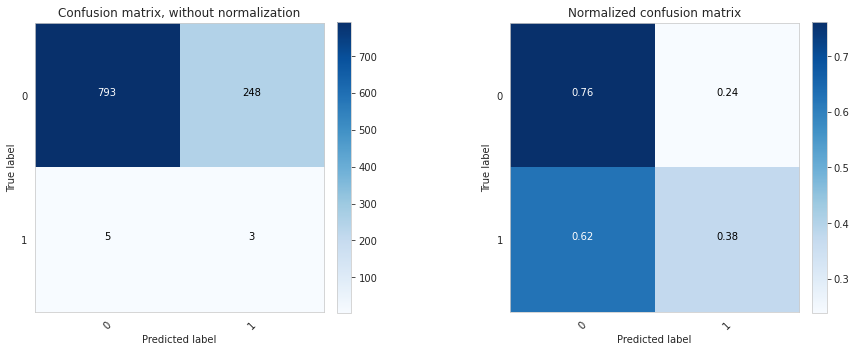

In [65]:
# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, classes=u_classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, classes=u_classes, normalize=True,
                      title='Normalized confusion matrix')

fig.subplots_adjust(wspace=0.5)
plt.show()

In [66]:
print(skm.classification_report(eval_targs, (eval_probs > threshold_f05).float(), 
                                labels=[0,1], 
                                sample_weight=None, 
                                zero_division=1))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1041
           1       0.01      0.38      0.02         8

    accuracy                           0.76      1049
   macro avg       0.50      0.57      0.44      1049
weighted avg       0.99      0.76      0.86      1049



#### Raw probability distribution

Useful to see how the threshold can be adjusted to increase sensitivity or specificity

Text(0, 0.5, 'Frequency')

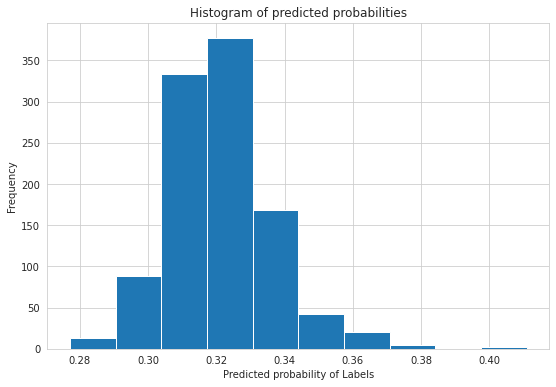

In [67]:
plt.hist(eval_probs, bins=10)
# plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Labels')
plt.ylabel('Frequency')

#### ROC curves and Area Under the Curve (AUC)

***ROC Curve*** answers the question, *"How would sensitivity and specificity be affected by various thresholds without changing the threshold?"*  It is a way **to visualize the performance of a binary classifier.**

The ROC curve can help you **choose a threshold** that balances sensitivity and specificity based on your particular business case.

ROC curves visualize all possible classification thresholds whereas misclassification rate only represents your error rate for a single threshold.

A classifier that does a good job at separating the classes will have a ROC curve that hugs the upper left corner of the plot.  Converseley, a classifier the does a poor job separating the classes will have a ROC curve that is close to the diagonal line (0,0 -> 1,1).  That diagonal line represents a classifier that does no better than random guessing.

In [68]:
fpr, tpr, thresholds = skm.roc_curve(eval_targs, eval_probs, sample_weight=None)

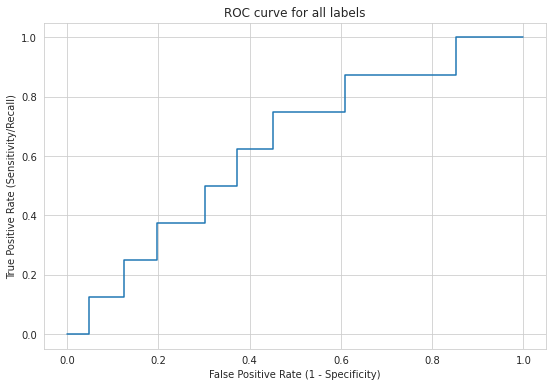

In [69]:
plt.plot(fpr, tpr)
plt.xlim = ([0.0, 1.0])
plt.ylim = ([0.0, 1.0])
plt.title('ROC curve for all labels')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity/Recall)')
plt.grid(True)

***AUC*** = the percentage of the ROC plot that is underneath the curve.  

AUC summarizes the performance of a classifier in a **single number**.  It says, *"If you randomly chose one positive and one negative observation, what is the likelihood that your classifier will assign a higher predicted probability to the positive observation."*

**An AUC of ~ 0.8 is very good while an AUC of ~ 0.5 represents a poor classifier.**

The ROC curve and AUC are insensitive to whether your predicted probabilities are properly calibrated to actually represent probabilities of class membership (e.g., it works if predicted probs range from 0.9 to 1 instead of 0 to 1).  All the AUC metric cares about is how well your classifier separated the two classes

Notes:
1.  AUC is useful even when there is **high class imbalance** (unlike classification accuracy)
2.  AUC is useful even when predicted probabilities are not properly calibrated (e.g., not between 0 and 1)

In [70]:
print(skm.roc_auc_score(eval_targs, eval_probs, average='weighted', sample_weight=None))

0.6300432276657061


### Overall metrics - is_example_prob_true

In [71]:
# mse
skm.mean_squared_error(targs[0], probs[0])

0.76950264

In [72]:
# rmse
math.sqrt(skm.mean_squared_error(targs[0], probs[0]))

0.8772129956689583

In [73]:
# mae
skm.mean_absolute_error(targs[0], probs[0])

0.69318205

## Train/Evaluate

In [74]:
try:
    inf_learn.purge(); inf_learn = None;
    gc.collect()
    torch.cuda.empty_cache()
except: pass

inf_learn = load_learner(STANDARD_THEME_META_PATH/f'{m_pre}export_mm{m_suf}.pkl')
inf_learn.loss_func.loss_funcs[1].func.weight = inf_learn.loss_func.loss_funcs[1].func.weight.to(dls.device)
dls = get_meta_standard_theme_train_dls(df, hf_arch, hf_tokenizer)
inf_learn.dls = dls

In [75]:
probs, targs, losses = inf_learn.get_preds(with_loss=True, reorder=True)

### Results

In [76]:
# determine optimal threshold based on desired f-score
f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.9, sigmoid=False, average='binary', sample_weight=None)
f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.9, sigmoid=False, average='binary', sample_weight=None)
f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.9, sigmoid=False, average='binary', sample_weight=None)

In [77]:
is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]

In [78]:
# determine optimal threshold based on desired f-score
threshold_f05 = f05.opt_th(is_example_prob_true, targs[1])
threshold_f1 = f1.opt_th(is_example_prob_true, targs[1])
threshold_f2 = f2.opt_th(is_example_prob_true, targs[1])

print(threshold_f05, threshold_f1, threshold_f2)

# determine accuracy based on optimal threshold
val_acc_f05 = accuracy_multi(is_example_prob_true, targs[1], threshold_f05, sigmoid=False).item()
val_acc_f1 = accuracy_multi(is_example_prob_true, targs[1], threshold_f1, sigmoid=False).item()
val_acc_f2 = accuracy_multi(is_example_prob_true, targs[1], threshold_f2, sigmoid=False).item()

print('Fowards Only\n-------------')
print(f'f05:\tOptimal threshold = {threshold_f05}\t(Accuracy = {val_acc_f05})')
print(f'f1:\tOptimal threshold = {threshold_f1}\t(Accuracy = {val_acc_f1})')
print(f'f2:\tOptimal threshold = {threshold_f2}\t(Accuracy = {val_acc_f2})')

print(f'\nAccuracy: {accuracy_multi(is_example_prob_true, targs[1], sigmoid=False)}')

0.33 0.33 0.33
Fowards Only
-------------
f05:	Optimal threshold = 0.33	(Accuracy = 0.7588179111480713)
f1:	Optimal threshold = 0.33	(Accuracy = 0.7588179111480713)
f2:	Optimal threshold = 0.33	(Accuracy = 0.7588179111480713)

Accuracy: 0.9923737049102783


In [79]:
mae = skm.mean_absolute_error(targs[0], probs[0])
mse = skm.mean_squared_error(targs[0], probs[0])
rmse = math.sqrt(skm.mean_squared_error(targs[0], probs[0]))

mae, mse, rmse

(0.69318205, 0.76950264, 0.8772129956689583)

In [80]:
final_valid_loss = loss.mean().item(); final_valid_loss

0.9588940143585205

## Codify our training/eval loop and score reporting

In [81]:
#export
def train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={}):
          
    config = {**meta_standard_themes_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    df = get_meta_standard_theme_train_data(train_config=config)
    train_df, valid_df = df[df.is_valid == False], df[df.is_valid == True]
    
    dls = get_meta_standard_theme_train_dls(df, hf_arch, hf_tokenizer, train_config=config)
    
    learn, fit_cbs = get_learner(hf_model, dls, train_df=None, use_weighted_loss=False, train_config=config)
    
    with learn.no_logging(): 
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(1, lr_max=lr_min, cbs=fit_cbs)
        
        learn.unfreeze()
        lr_min, lr_steep = learn.lr_find()
        learn.fit_one_cycle(10, lr_max=slice(lr_min/10, lr_min), cbs=fit_cbs)
        
        # export model for inference (SavedModelCallback already saves the best model)
        learn.export(fname=config['export_filename'])
        
    # ===== fetch scores, probs, targs, losses, and optional f-scores/thresholds ====
    learn = learn.load(config['save_model_filename'])
    scores = dict(zip(learn.recorder.metric_names[2:], learn.validate()))
    probs, targs, losses = learn.get_preds(dl=dls.valid, with_loss=True)
    
    # determine optimal threshold based on desired f-score
    average, sample_weight = config['opt_beta_average'], config['opt_beta_sample_weight']

    f05 = OptimalMultiThresholdMetrics(beta=0.5, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f1 = OptimalMultiThresholdMetrics(beta=1, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)
    f2 = OptimalMultiThresholdMetrics(beta=2, start=0.05, end=.5, sigmoid=False, 
                                       average=average, sample_weight=sample_weight)

    is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
    scores['is_example_f05'], scores['is_example_f1'], scores['is_example_f2'] = {}, {}, {}
    
    scores['is_example_f05']['threshold'] = f05.opt_th(is_example_prob_true, targs[1])
    scores['is_example_f1']['threshold'] = f1.opt_th(is_example_prob_true, targs[1])
    scores['is_example_f2']['threshold'] = f2.opt_th(is_example_prob_true, targs[1])
    
    scores['is_example_f05']['score'] = f05.opt_fscore(is_example_prob_true, targs[1])
    scores['is_example_f1']['score'] = f1.opt_fscore(is_example_prob_true, targs[1])
    scores['is_example_f2']['score'] = f2.opt_fscore(is_example_prob_true, targs[1])
    
    scores['sentiment'] = {
        'mae': skm.mean_absolute_error(targs[0], probs[0]),
        'mse': skm.mean_squared_error(targs[0], probs[0]),
        'rmse': math.sqrt(skm.mean_squared_error(targs[0], probs[0]))
    }
    
    # save scores from validation set    
    yyyymmdd = datetime.today().strftime("%Y%m%d")
          
    with open(f"{config['learner_path']}/{yyyymmdd}_model_scores{m_suf}.pkl", 'wb') as f:
        pickle.dump(scores, f)
        
    # save train/validation probs, targs, losses for review
    test_dl = dls.test_dl(df, with_labels=True)
    probs, targs, losses = learn.get_preds(dl=test_dl, with_loss=True)
    is_example_prob_true = torch.softmax(probs[1], dim=-1)[:,1]
    
    probs_df = pd.DataFrame(np.concatenate((probs[0].numpy(), is_example_prob_true[:,None]), axis=-1), 
                            columns=['pred_sentiment', 'prob_is_example'])
    targs_df = pd.DataFrame(np.concatenate((targs[0].numpy()[:,None], targs[1].numpy()[:,None]), axis=-1), 
                            columns= ['targ_sentiment', 'targ_is_example'])
    losses_df = pd.DataFrame(losses.numpy(), columns=['loss'])
    final_df = pd.concat([df.reset_index(), probs_df, targs_df, losses_df], axis=1)
    
    final_df.to_csv(f"{config['learner_path']}/{yyyymmdd}_model_preds{m_suf}.csv", index=False)
        
    return scores, final_df

In [82]:
task = HF_TASKS_AUTO.SequenceClassification

pretrained_model_name = 'facebook/bart-base' #"bert-base-cased" #"roberta-base"
config = AutoConfig.from_pretrained(pretrained_model_name)
config.attention_probs_dropout_prob = 0.1 * 2
config.hidden_dropout_prob = 0.1 * 2

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR_MODEL_HELPER.get_hf_objects(pretrained_model_name, 
                                                                               task=task, 
                                                                               config=config)

Some weights of the model checkpoint at facebook/bart-base were not used when initializing BartForSequenceClassification: ['final_logits_bias']
- This IS expected if you are initializing BartForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.weight', 'classification_head.dense.bias', 'classification_head.out_proj.weight', 'classification_head.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to u

Better model found at epoch 0 with valid_loss value: 0.4347231388092041.


Better model found at epoch 0 with valid_loss value: 0.4346519112586975.
Better model found at epoch 1 with valid_loss value: 0.43394577503204346.
Better model found at epoch 2 with valid_loss value: 0.43303728103637695.
Better model found at epoch 3 with valid_loss value: 0.43158549070358276.
Better model found at epoch 4 with valid_loss value: 0.43014824390411377.
Better model found at epoch 5 with valid_loss value: 0.42900246381759644.
Better model found at epoch 6 with valid_loss value: 0.4281807541847229.
Better model found at epoch 7 with valid_loss value: 0.4278009831905365.
Better model found at epoch 8 with valid_loss value: 0.4276268482208252.


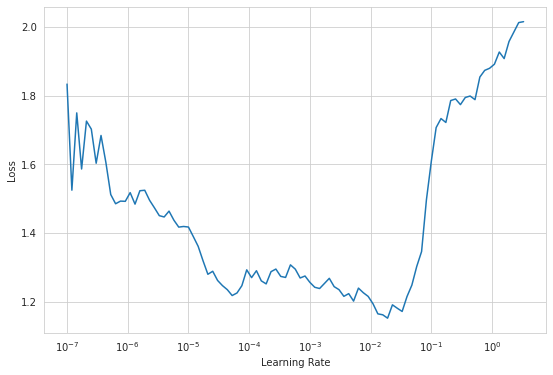

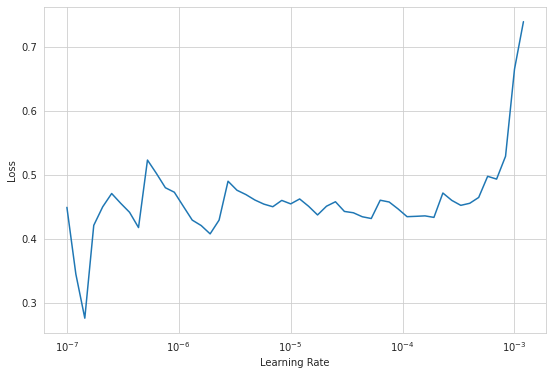

In [83]:
scores, preds_df = train(hf_arch, hf_config, hf_tokenizer, hf_model, train_config={})

In [84]:
scores

{'valid_loss': 0.4276268482208252,
 'sentiment_mse': 0.42372608184814453,
 'is_example_acc': 0.9923737049102783,
 'is_example_f05': {'threshold': 0.28, 'score': 0.11029411764705882},
 'is_example_f1': {'threshold': 0.28, 'score': 0.15},
 'is_example_f2': {'threshold': 0.28, 'score': 0.234375},
 'sentiment': {'mae': 0.4667339, 'mse': 0.42372608, 'rmse': 0.650942456633568}}

In [85]:
preds_df.head()

,index,id,question_ans_id,answer_text,answer_text_non_english,language,survey_id,survey_type_id,benchmark_survey_type,client_id,rsp_id,question_category_abbr,question_text,question_class,question_category_id,question_report_abbr,question_category_label,benchmark_level1,benchmark_level2,benchmark_level3,client_benchmark_level,group_code,group_id,group_level1_code,group_level1_name,group_level2_code,group_level2_name,group_level3_code,group_level3_name,group_level4_code,group_level4_name,group_level5_code,group_level5_name,group_level6_code,group_level6_name,group_level7_code,group_level7_name,group_level8_code,group_level8_name,standard_theme_id,theme,url_friendly_theme,theme_display_order,avg_sentiment,is_example,is_valid,pred_sentiment,prob_is_example,targ_sentiment,targ_is_example,loss
0,0,594369,12281,Handling things such as child support and wage garnishment/levies is inconsistent and has led to...,NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,453733,Payroll,Let us know your suggestions on how to improve Payroll.,Verbatim-Dept-Improve,88.0,Payroll_Improve,Payroll,Human Resources,Payroll Services,Payroll,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,"Consistency in Policies, Information",ConsistencyInPoliciesInformation,1,2.0,0,False,1.968750,0.271205,2.0,0.0,0.001552
1,1,589686,2576,Diversity is such an important part o UC mission and yet some places its not seen as much it is ...,NaN,English,212,9,SAW,UCSD,447092,C&B,21. If you would like to elaborate on any of your answers to the conduct and behavioral question...,Verbatim,1240.0,Conduct & Behavioral - Comments,Conduct & Behavioral,None,None,None,3.0,90890.0,3662,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,90890.0,DERMATOLOGY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,Satisfied with Diversity Progams,SatisfiedWithDiversityProgams,1,2.5,0,False,2.960938,0.270682,2.5,0.0,0.212906
2,2,605320,75138,Better trained technicians. Better communication within the online post box. Check the online po...,NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,457424,IT Serviec Desk,Let us know your suggestions on how to improve ITS Service Desk.,Verbatim-Dept-Improve,56.0,ITS Service Desk_Improve,IT Service Desk,ITS,ITS - General,IT Help Desk,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,Resolves Problems Effectively,ResolvesProblemsEffectively,1,2.0,0,False,1.935547,0.269454,2.0,0.0,0.004284
3,3,588932,1877,"The past 3-4 years, I feel my co-worker took extensive credit for the work that couldn't have be...",NaN,English,212,9,SAW,UCSD,449351,None,"59. If you would like to elaborate on your responses above, or if you have any additional feedba...",Verbatim,201.0,Comments re Work Environment at UCSD,Other,None,None,None,1.0,11804.0,3482,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10016.0,UNIVERSITY LIBRARY,11804.0,LIBRARY - ENTERPRISE SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,Favoritism/Cliques,FavoritismCliques,1,2.0,0,False,2.417969,0.274234,2.0,0.0,0.176045
4,4,594169,12244,Great,NaN,English,215,15,CSS-FACULTY-STAFF-ONLY,UCSD,453580,Dining,Let us know your suggestions on how to improve HDH Dining Services.,Verbatim-Dept-Improve,69.0,Dining_Improve,Dining Services,Auxiliary Services,"Dining, Catering, & Retail Services",Dining Services,1.0,-1.0,-1,-1.0,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37,Overall Satisfaction,OverallSatisfaction,1,3.0,0,False,4.335938,0.269186,3.0,0.0,1.784791


In [86]:
# load results
with open(STANDARD_THEME_META_PATH/'20201013_model_scores_multitask_hf.pkl', 'rb') as f:
    training_results = pickle.load(f)
    
training_results

{'valid_loss': 0.4276268482208252,
 'sentiment_mse': 0.42372608184814453,
 'is_example_acc': 0.9923737049102783,
 'is_example_f05': {'threshold': 0.28, 'score': 0.11029411764705882},
 'is_example_f1': {'threshold': 0.28, 'score': 0.15},
 'is_example_f2': {'threshold': 0.28, 'score': 0.234375},
 'sentiment': {'mae': 0.4667339, 'mse': 0.42372608, 'rmse': 0.650942456633568}}

In [87]:
inf_learn = load_learner(STANDARD_THEME_META_PATH/'export_mm_multitask_hf.pkl')
print(inf_learn.blurr_predict('theme: Benefits comment: We are not paid enough and the benefits are horrible'))
print(inf_learn.blurr_predict("theme: Benfits comment: The faculty really support us well!!! I feel valued"))

(((1.8604860305786133,), '0'), tensor([[1.8605]]), tensor([[1.8605]]))


(((4.3606038093566895,), '0'), tensor([[4.3606]]), tensor([[4.3606]]))


## Inference

### Inference (ad-hoc documents)

In [88]:
print(STANDARD_THEME_SAW_LABELS[:5])

['adequate_staffing', 'advancement_and_training_opportunities', 'appropriate_stress_work_assigned_equitably', 'benefits', 'better_ways_recognized_participate_in_decisions']


In [89]:
test_comments = [
    'theme: Benfits comment: Not paid enough.',
    'theme: Benfits comment: I am satisfied with my benefits and we have enough people in my department. The faculty is mean to me.',
    'theme: Benfits comment: I love cats',
    "theme: Benfits comment: I can never find a parking spot. The shuttles are not on time. Help",
    "theme: Benfits comment: I was really uncomfortable to express my opinion!!!",
    "theme: Benfits comment: Jeff Wadell is an exceptional leader.  He has gone above and beyond to create a positive working environment and provide growth opportunities.  His commitment to his team is unrivaled and commendable.\\r\\n\\r\\nNikki Panza is a model of authentic leadership for Building and Custodial Services.  She has earned the respect of those she leads through honest communication, empathy, and ethical consultation."
]

for c in test_comments: print(inf_learn.blurr_predict(c, with_input=True))

(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,  1491,  1199,   615,
            4,     2]), ((2.002136707305908,), '0'), tensor([[2.0021]]), tensor([[2.0021]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,   524, 10028,
           19,   127,  1795,     8,    52,    33,   615,    82,    11,   127,
         1494,     4,    20,  7998,    16,  1266,     7,   162,     4,     2]), ((2.5888965129852295,), '0'), tensor([[2.5889]]), tensor([[2.5889]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,   657, 10017,
            2]), ((3.7853071689605713,), '0'), tensor([[3.7853]]), tensor([[3.7853]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,    64,   393,
          465,    10,  2932,  1514,     4,    20,  2572,    90,  1634,    32,
           45,    15,    86,     4, 10310,     2]), ((1.9403767585754395,), '0'), tensor([[1.9404]]), tensor([[1.9404]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,    38,    21,   269,
         9800,     7,  5486,   127,  2979, 16506,     2]), ((1.9915456771850586,), '0'), tensor([[1.9915]]), tensor([[1.9915]]))


(HF_BaseInput([    0,  4782,    35,  1664, 30769,  1129,    35,  2321,  8914,   890,
           16,    41,  9297,   884,     4,  1437,    91,    34,  1613,  1065,
            8,  1684,     7,  1045,    10,  1313,   447,  1737,     8,   694,
          434,  1616,     4,  1437,   832,  2720,     7,    39,   165,    16,
          542, 27978,   196,     8, 19781,   868,     4, 37457,   338, 37457,
          282, 37457,   338, 37457,   282, 38334,  3144,  5302,  2478,    16,
           10,  1421,     9, 12757,  1673,    13,  6919,     8, 37513,  1630,
         2617,  1820,     4,  1437,   264,    34,  2208,     5,  2098,     9,
          167,    79,  3315,   149,  5322,  4358,     6, 17805,     6,     8,
        13557,  9434,     4,     2]), ((4.224795341491699,), '0'), tensor([[4.2248]]), tensor([[4.2248]]))


### Inference (batch)

In [139]:
#export
def get_standard_theme_preds(inf_df, learner_export_path=None, device=torch.device('cpu'), train_config={}):
    config = {**meta_standard_themes_train_config, **train_config}    
    m_pre, m_suf = config['m_pre'], config['m_suf']
    
    # 1. grab learner, procs, and data
    cpu = device.type == 'cpu'
    if (learner_export_path is None): learner_export_path = f"{config['learner_path']}/{config['export_filename']}"
        
    inf_learn = load_learner(fname=learner_export_path, cpu=cpu)
    inf_learn.model = inf_learn.model.to(device)
    inf_learn.model = inf_learn.model.eval()
    
    # 2. define a suitable dataloader
    inf_dl = inf_learn.dls.test_dl(inf_df, rm_type_tfms=None, bs=16)

    # 3. get probs and document vectors
    test_probs_sent, test_probs_is_example = [], []
    with torch.no_grad():
        for index, b in enumerate(inf_dl):
            if index % 1000 == 0:  print(index)

            # note: even though there is no targets, each batch is a tuple!
            probs = inf_learn.model(b[0])
            
            # why "detach"? the computation of gradients wrt the weights of netG can be fully 
            # avoided in the backward pass if the graph is detached where it is.
            test_probs_sent.append(to_detach(probs[0][0]))
            test_probs_is_example.append(to_detach(torch.softmax(probs[0][1], dim=-1)))

    all_probs_sent = L(torch.cat(test_probs_sent))
    all_probs_is_example = L(torch.cat(test_probs_is_example))

    # 4. ensure results are returned in order
    # test_dl.get_idxs() => unsorted/original order items
    all_probs_sent = all_probs_sent[0][np.argsort(inf_dl.get_idxs())]
    all_probs_is_example = all_probs_is_example[0][np.argsort(inf_dl.get_idxs())]
        
    # 5. return ordered results
    inf_learn, inf_dl = None, None; gc.collect()
    
    return all_probs_sent, all_probs_is_example

In [112]:
verbatims_df = pd.read_csv(STANDARD_THEME_SAW_PATH/'20201013_test_predictions_multilabel_hf.csv', 
                           dtype={**TASK_LM_DTYPES}, parse_dates=[])

inf_df = verbatims_df.copy() #verbatims_df[test_df.SurveyID == 130].copy()
inf_df.reset_index(drop=True, inplace=True)
print(len(verbatims_df), len(inf_df))

corpus_cols = ['theme', 'AnswerText'] 

4045 4045


In [113]:
inf_df.head(1)

,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,answer_text,prob_adequate_staffing,prob_advancement_and_training_opportunities,prob_appropriate_stress_work_assigned_equitably,prob_benefits,prob_better_ways_recognized_participate_in_decisions,prob_career_advancement,prob_committed_to_diversity,prob_communicates_essential_information,prob_ethical_conduct_perform_responsibilities_spirit_of_cooperation,prob_evaluated_fairly,prob_experienced_discrimination,prob_facilities_workspace_safety,prob_faculty_value_contributions,prob_favoritism_cliques,prob_fear_of_retaliation_negative_consequences,prob_feel_valued_by_department,prob_flexibility_work_life_balance,prob_good_use_of_skills,prob_have_necessary_tools,prob_have_voice_within_my_institution_valued_member_of_my_institution,prob_internal_processes_effective,prob_parking_transportation,prob_salary_pay,prob_satisfied_with_diversity_progams,prob_supervisor_effectiveness_resolves_staff_issues,pred_adequate_staffing,pred_advancement_and_training_opportunities,pred_appropriate_stress_work_assigned_equitably,pred_benefits,pred_better_ways_recognized_participate_in_decisions,pred_career_advancement,pred_committed_to_diversity,pred_communicates_essential_information,pred_ethical_conduct_perform_responsibilities_spirit_of_cooperation,pred_evaluated_fairly,pred_experienced_discrimination,pred_facilities_workspace_safety,pred_faculty_value_contributions,pred_favoritism_cliques,pred_fear_of_retaliation_negative_consequences,pred_feel_valued_by_department,pred_flexibility_work_life_balance,pred_good_use_of_skills,pred_have_necessary_tools,pred_have_voice_within_my_institution_valued_member_of_my_institution,pred_internal_processes_effective,pred_parking_transportation,pred_salary_pay,pred_satisfied_with_diversity_progams,pred_supervisor_effectiveness_resolves_staff_issues
0,589404,1877,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",NaN,English,212,9,SAW,UCSD,451700,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,91925.0,6878,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,91900.0,SURGERY,91925.0,DIVISION ADMIN,NaN,NaN,NaN,NaN,NaN,NaN,"Some of the answers that are marked as agreed, as I think there is always room for improvement. ...",0.017574,0.152109,0.01798,0.000897,0.096773,0.009805,0.021668,0.087357,0.540619,0.006133,0.002876,0.032856,0.058381,0.002821,0.03437,0.014816,0.000873,0.020616,0.000665,0.016983,0.150064,0.000333,0.000928,0.032198,0.069896,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
pred_theme_cols = filter_col = [col for col in inf_df if col.startswith('pred_')]
# pred_theme_cols

In [115]:
inf_df = inf_df.melt(id_vars=list(TASK_LM_DTYPES.keys()), 
                     value_vars=pred_theme_cols, 
                     var_name='theme', 
                     value_name='theme_pred')
len(inf_df)

101125

In [116]:
inf_df = inf_df.loc[inf_df.theme_pred == 1]
len(inf_df)

4286

In [117]:
inf_df['url_friendly_theme'] = inf_df.theme.apply(
    lambda s: re.sub("(.*?)_([a-zA-Z])","\g<1> \g<2>",s).replace('pred', '').strip().title().replace(' ',''))

inf_df['theme'] = inf_df.url_friendly_theme.apply(lambda s: re.sub("([a-z])([A-Z])","\g<1> \g<2>",s))
inf_df['answer_text'] = inf_df['AnswerText']

In [118]:
inf_df.reset_index(inplace=True)

In [119]:
inf_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text
0,8,588956,1877,There are ongoing issues in our department that make for an often awkward and uncomfortable work...,NaN,English,212,9,SAW,UCSD,449462,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11200.0,3472,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10011.0,COLLEGES,11200.0,ROOSEVELT COLLEGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,There are ongoing issues in our department that make for an often awkward and uncomfortable work...
1,26,588454,1877,Workload is unbalanced and needs to be reassessed. Management constantly expresses that volume i...,NaN,English,212,9,SAW,UCSD,447089,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,96023.0,3855,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,96015.0,VCHS ACADEMIC RESOURCE CENTER (ARC),96023.0,COMPENSATION & TIMEKEEPING,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Workload is unbalanced and needs to be reassessed. Management constantly expresses that volume i...
2,32,589390,1877,"Doctors and supervisors are supportive. However, clinical trials are very busy and sometimes I f...",NaN,English,212,9,SAW,UCSD,451657,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,98200.0,3631,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,98000.0,CANCER CENTER,98200.0,CLINICAL TRIALS OFFICE (CTO),NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"Doctors and supervisors are supportive. However, clinical trials are very busy and sometimes I f..."
3,48,590606,9439,Evaluate staffing and productivity for the urgent care/walk in clinic as well as the walk in nur...,NaN,English,212,9,SAW,UCSD,450625,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,31302.0,3555,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,90563.0,STUDENT HEALTH & WELL BEING,31302.0,STUDENT HEALTH SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Evaluate staffing and productivity for the urgent care/walk in clinic as well as the walk in nur...
4,70,588546,1877,This VC area does a poor job of managing resources (both human and monetary). Initiatives are of...,NaN,English,212,9,SAW,UCSD,447652,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,12011.0,3783,999999.0,UC San Diego,12000.0,VC-RESEARCH AFFAIRS,12011.0,RESEARCH AFFAIRS - SENIOR MANAGEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,This VC area does a poor job of managing resources (both human and monetary). Initiatives are of...


In [140]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

inf_probs_sent, inf_probs_is_example = get_standard_theme_preds(inf_df, device=device)
print(inf_probs_sent.shape, inf_probs_is_example.shape)

cuda:1
0
torch.Size([4286, 1]) torch.Size([4286, 2])


Add the probabilities of each label to `inf_df`

In [141]:
inf_probs_is_example.numpy().shape

(4286, 2)

In [142]:
np.concatenate((inf_probs_sent.numpy(), inf_probs_is_example.numpy()[:,1][:,None]), axis=1)

array([[2.0719056e+00, 4.5130560e-03],
       [2.0534282e+00, 3.1740253e-03],
       [3.3183842e+00, 1.3612753e-03],
       ...,
       [2.0770049e+00, 1.0045206e-02],
       [4.3059611e+00, 6.7040185e-03],
       [4.3792539e+00, 7.3828311e-03]], dtype=float32)

In [143]:
combined_probs = np.concatenate((inf_probs_sent.numpy(), inf_probs_is_example.numpy()[:,1][:,None]), axis=1)

In [144]:
prob_labels = ['prob_' + lbl for lbl in STANDARD_THEME_META_LABELS]
probs_df = pd.DataFrame(combined_probs, columns=prob_labels)
probs_df.head()

,prob_avg_sentiment,prob_is_example
0,2.071906,0.004513
1,2.053428,0.003174
2,3.318384,0.001361
3,2.118701,0.005070
4,2.118699,0.006251


In [145]:
# test_df_filtered.update(probs_df)
final_df = pd.concat([inf_df, probs_df], axis=1)
final_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text,prob_avg_sentiment,prob_is_example
0,8,588956,1877,There are ongoing issues in our department that make for an often awkward and uncomfortable work...,NaN,English,212,9,SAW,UCSD,449462,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11200.0,3472,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10011.0,COLLEGES,11200.0,ROOSEVELT COLLEGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,There are ongoing issues in our department that make for an often awkward and uncomfortable work...,2.071906,0.004513
1,26,588454,1877,Workload is unbalanced and needs to be reassessed. Management constantly expresses that volume i...,NaN,English,212,9,SAW,UCSD,447089,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,96023.0,3855,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,96015.0,VCHS ACADEMIC RESOURCE CENTER (ARC),96023.0,COMPENSATION & TIMEKEEPING,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Workload is unbalanced and needs to be reassessed. Management constantly expresses that volume i...,2.053428,0.003174
2,32,589390,1877,"Doctors and supervisors are supportive. However, clinical trials are very busy and sometimes I f...",NaN,English,212,9,SAW,UCSD,451657,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,98200.0,3631,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,98000.0,CANCER CENTER,98200.0,CLINICAL TRIALS OFFICE (CTO),NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"Doctors and supervisors are supportive. However, clinical trials are very busy and sometimes I f...",3.318384,0.001361
3,48,590606,9439,Evaluate staffing and productivity for the urgent care/walk in clinic as well as the walk in nur...,NaN,English,212,9,SAW,UCSD,450625,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,31302.0,3555,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,90563.0,STUDENT HEALTH & WELL BEING,31302.0,STUDENT HEALTH SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Evaluate staffing and productivity for the urgent care/walk in clinic as well as the walk in nur...,2.118701,0.005070
4,70,588546,1877,This VC area does a poor job of managing resources (both human and monetary). Initiatives are of...,NaN,English,212,9,SAW,UCSD,447652,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,12011.0,3783,999999.0,UC San Diego,12000.0,VC-RESEARCH AFFAIRS,12011.0,RESEARCH AFFAIRS - SENIOR MANAGEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,This VC area does a poor job of managing resources (both human and monetary). Initiatives are o

Add in predictions based on f05 threshold

In [147]:
threshold_f05

0.33

In [148]:
for lbl in STANDARD_THEME_META_LABELS[1:]:
    final_df[f'pred_{lbl}'] = (final_df[f'prob_{lbl}'] > threshold_f05).astype(np.int64)

In [149]:
final_df.head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text,prob_avg_sentiment,prob_is_example,pred_is_example
0,8,588956,1877,There are ongoing issues in our department that make for an often awkward and uncomfortable work...,NaN,English,212,9,SAW,UCSD,449462,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,11200.0,3472,999999.0,UC San Diego,10000.0,ACADEMIC AFFAIRS,10011.0,COLLEGES,11200.0,ROOSEVELT COLLEGE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,There are ongoing issues in our department that make for an often awkward and uncomfortable work...,2.071906,0.004513,0
1,26,588454,1877,Workload is unbalanced and needs to be reassessed. Management constantly expresses that volume i...,NaN,English,212,9,SAW,UCSD,447089,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,96023.0,3855,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,96015.0,VCHS ACADEMIC RESOURCE CENTER (ARC),96023.0,COMPENSATION & TIMEKEEPING,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Workload is unbalanced and needs to be reassessed. Management constantly expresses that volume i...,2.053428,0.003174,0
2,32,589390,1877,"Doctors and supervisors are supportive. However, clinical trials are very busy and sometimes I f...",NaN,English,212,9,SAW,UCSD,451657,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,98200.0,3631,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,93000.0,SCHOOL OF MEDICINE,98000.0,CANCER CENTER,98200.0,CLINICAL TRIALS OFFICE (CTO),NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,"Doctors and supervisors are supportive. However, clinical trials are very busy and sometimes I f...",3.318384,0.001361,0
3,48,590606,9439,Evaluate staffing and productivity for the urgent care/walk in clinic as well as the walk in nur...,NaN,English,212,9,SAW,UCSD,450625,None,The Standing Committee on Service and People Oriented Culture (SC-SPOC) is interested in learnin...,Verbatim,201.0,IdeaWave Comments,Other,None,None,None,1,31302.0,3555,999999.0,UC San Diego,90000.0,VICE CHANCELLOR HEALTH SCIENCES,90563.0,STUDENT HEALTH & WELL BEING,31302.0,STUDENT HEALTH SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,Evaluate staffing and productivity for the urgent care/walk in clinic as well as the walk in nur...,2.118701,0.005070,0
4,70,588546,1877,This VC area does a poor job of managing resources (both human and monetary). Initiatives are of...,NaN,English,212,9,SAW,UCSD,447652,SAT,"If you would like to elaborate on your responses above, or if you have any additional feedback r...",Verbatim,114.0,Comments re Work Environment at UCSD,Satisfaction with UC San Diego,None,None,None,1,12011.0,3783,999999.0,UC San Diego,12000.0,VC-RESEARCH AFFAIRS,12011.0,RESEARCH AFFAIRS - SENIOR MANAGEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adequate Staffing,1,AdequateStaffing,This VC area does a poor job of managing resources (both human and mone

## Cleanup

In [150]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 02a_verbatims-core.ipynb.
Converted 02c_verbatims-standard-themes-saw-training.ipynb.
Converted 02e_verbatims-standard-themes-meta-training.ipynb.
Converted 99_verbatims-inference.ipynb.
Converted Untitled.ipynb.
Converted index.ipynb.


## Playground

In [153]:
verbatim_id = 589305

pred_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_META_LABELS ]
prob_lbls = [ f'prob_{lbl}' for lbl in STANDARD_THEME_META_LABELS ]

print("=== text ===")
print(final_df.AnswerText[final_df.Id == verbatim_id].values[0])
print('\n=== preds ===')
preds = final_df[pred_lbls][final_df.Id == verbatim_id].values[0]
print(preds)

=== text ===
One thing that is discouraging is that it doesn't seem that under performers or unreliable co-workers get addressed. It has been years.\r\n\r\nA positive is I was hugely encouraged by how quickly campus administration addressed a hate issue and took excellent care of the victim.

=== preds ===
[3.284809   0.00522985]


In [155]:
final_df[final_df.pred_is_example == 1].head()

,index,Id,QuestionAnsID,AnswerText,AnswerText_NonEnglish,Language,SurveyID,SurveyTypeID,BenchmarkSurveyType,ClientId,RspID,QuestionCategoryAbbr,QuestionText,QuestionClass,QuestionCategoryID,QuestionReportAbbr,QuestionCategoryLabel,BenchmarkLevel1,BenchmarkLevel2,BenchmarkLevel3,ClientBenchmarkLevel,GroupCode,GroupID,GroupLevel1Code,GroupLevel1Name,GroupLevel2Code,GroupLevel2Name,GroupLevel3Code,GroupLevel3Name,GroupLevel4Code,GroupLevel4Name,GroupLevel5Code,GroupLevel5Name,GroupLevel6Code,GroupLevel6Name,GroupLevel7Code,GroupLevel7Name,GroupLevel8Code,GroupLevel8Name,theme,theme_pred,url_friendly_theme,answer_text,prob_avg_sentiment,prob_is_example,pred_is_example


In [158]:
final_df.prob_is_example.max()

0.08772729

In [160]:
threshold_f05, threshold_f1, threshold_f2

(0.33, 0.33, 0.33)